In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


experiment_name = "baseline_far.classifier.cnn_4_retinas.vggsmall"
metadata_path = "data/mined_retinas_0"
data_path = "./data/sig56/"

reference_df_path = "data/decays/far_ks_counts_56.csv"


generate_metadata = not os.path.exists(metadata_path)

if generate_metadata:
    print "Metadata does not exist. This run might be MUCH longer due to preprocessing the data."

/home/jheuristic/yozhik/ksfinder


In [2]:
#import theano stack
%env THEANO_FLAGS="device=gpu1"

import lasagne
import theano
import theano.tensor as T
from lib.retina_compiled import retinize_events

floatX = theano.config.floatX


env: THEANO_FLAGS="device=gpu1"


Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN 4004)


## Preprocess/Load data

In [3]:
from lib.retina_compiled import retina_view

retina_images_path = os.path.join(metadata_path,"retina_images.npy")
answers_path = os.path.join(metadata_path,"decay_counts_far.npy")

if generate_metadata:
    

    #event names
    df_ref = pd.DataFrame.from_csv(reference_df_path,index_col=None)

    param_df = pd.DataFrame.from_csv("./baseline_mined_retina_params.csv")
    #param_df.xdim=64
    #param_df.ydim=64
    retinas = [retina_view(*params) for params in param_df.values]

    X = retinize_events(df_ref.X_filename.values[:5000],
                             data_path,retina_views=retinas,
                             max_hits_block=15000,report_rate=100)
    
    y = df_ref.relevant_decay_count.values[:5000] >0
    
    os.mkdir(metadata_path)
    np.save(retina_images_path,X)
    np.save(answers_path, y)
    
    generate_metadata = False
else:
    #load metadata
    X = np.load(retina_images_path)
    y = np.load(answers_path)

In [4]:
X.shape

(5000, 10240)

In [5]:
X = X.reshape([5000,-1,32,32])

X = X.astype(floatX)
y = y.astype('int32')

In [6]:
from sklearn.cross_validation import train_test_split
Xtr, Xts, Ytr,Yts = train_test_split(X,y,test_size=0.25,random_state=1337)

print Ytr.shape,Yts.shape

(3750,) (1250,)


In [7]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(verbose=True).fit(Xtr.reshape([len(Xtr),-1]),Ytr)
Yts_pred = lr.predict_proba(Xts.reshape([len(Xts),-1]))[:,1]
Ytr_pred = lr.predict_proba(Xtr.reshape([len(Xtr),-1]))[:,1]

from sklearn.metrics import roc_auc_score
print roc_auc_score(Yts,Yts_pred)
print roc_auc_score(Ytr,Ytr_pred)

/home/jheuristic/thenv/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:701: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min finished


0.518127720183
0.651226973617


# define NN

In [22]:
input_dim = (None,)+X.shape[1:]

retina_dim = (None,1) + X.shape[2:]

retina_images = T.tensor4("input_images","floatX")

any_interesting_decays = T.ivector("mctruith_any_decays")

In [23]:
concatenated_retinas = retina_images.reshape([retina_images.shape[0],1,-1,retina_images.shape[-1]])

concatenated_dim = (None,1,np.prod(X.shape[1:-1]),X.shape[-1])

In [24]:
from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import DenseLayer, DropoutLayer

#nn where each retina is processed with a separate CNN

net = {}

net['input'] = InputLayer(concatenated_dim,input_var=concatenated_retinas)
net['conv1_1'] = ConvLayer(
            net['input'], 256, 5, pad=1, flip_filters=False)
net['pool1'] = PoolLayer(net['conv1_1'], 3)
net['conv2_1'] = ConvLayer(
            net['pool1'], 256, 5, pad=1, flip_filters=False)
net['pool2'] = PoolLayer(net['conv2_1'], 3)
    
net['fc6'] = DenseLayer(net["pool2"], num_units=1024)
#net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.1)

net['out'] = DenseLayer(net['fc6'], num_units=2, 
                        nonlinearity=lasagne.nonlinearities.softmax)



In [25]:
weights = lasagne.layers.get_all_params(net["out"],trainable=True)
weights

[W, b, W, b, W, b, W, b]

# train updates

In [26]:
train_prediction = lasagne.layers.get_output(net["out"])
train_loss_ce = lasagne.objectives.categorical_crossentropy(train_prediction,any_interesting_decays).mean()
train_accuracy = lasagne.objectives.categorical_accuracy(train_prediction,any_interesting_decays).mean()
updates = lasagne.updates.rmsprop(train_loss_ce,weights,learning_rate=0.001) 
#ik that lr does not matter. I just dont want an explosion.

In [27]:
train_fun = theano.function([retina_images,any_interesting_decays],[train_loss_ce,train_accuracy,train_prediction[:,1]], updates=updates)

# evaluation

In [28]:
prediction = lasagne.layers.get_output(net["out"],deterministic=True)
loss_ce = lasagne.objectives.categorical_crossentropy(prediction,any_interesting_decays).mean()
accuracy = lasagne.objectives.categorical_accuracy(prediction,any_interesting_decays).mean()

In [29]:
eval_fun = theano.function([retina_images,any_interesting_decays], [loss_ce,accuracy,prediction[:,1]])
predict_fun = theano.function([retina_images],prediction)

# main loop
* almost copies the layout of lasagne basic training 

In [30]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False,crop_at=None):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if crop_at == start_idx:
            break
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        


In [31]:
from collections import defaultdict
from sklearn.metrics import roc_auc_score
metrics = defaultdict(dict)

import time
num_epochs = 100
batch_size = 50

# We iterate over epochs:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    y_pred_batches = []
    y_ref_batches = []
    for batch in iterate_minibatches(Xtr, Ytr, batch_size, shuffle=True):
        batch_ce,batch_acc,pred_batch= train_fun(*batch)
        train_err +=batch_ce
        train_acc +=batch_acc
        train_batches += 1
        y_pred_batches.append(pred_batch)
        y_ref_batches.append(batch[1])
        
    y_pred = np.concatenate(y_pred_batches)
    y_ref = np.concatenate(y_ref_batches)
    train_auc = roc_auc_score(y_ref,y_pred)

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    y_pred_batches = []
    y_ref_batches = []
    for batch in iterate_minibatches(Xts, Yts, batch_size, shuffle=False):
        err, acc,pred_batch = eval_fun(*batch)
        val_err += err
        val_acc += acc
        val_batches += 1
        y_pred_batches.append(pred_batch)
        y_ref_batches.append(batch[1])

    y_pred = np.concatenate(y_pred_batches)
    y_ref = np.concatenate(y_ref_batches)
    val_auc = roc_auc_score(y_ref,y_pred)

    metrics["acc_train"][epoch] = train_acc
    metrics["auc_train"][epoch] = train_auc
    metrics["acc_test"][epoch] = val_acc
    metrics["auc_test"][epoch] = val_auc
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  training ROC AUC:\t\t{:.3f} %".format(
        train_auc))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    print("  validation ROC AUC:\t\t{:.3f} %".format(
        val_auc))



Epoch 1 of 100 took 38.178s
  training loss:		327.693116
  training accuracy:		50.21 %
  training ROC AUC:		0.506 %
  validation loss:		0.707796
  validation accuracy:		48.72 %
  validation ROC AUC:		0.496 %
Epoch 2 of 100 took 37.991s
  training loss:		4.169392
  training accuracy:		49.71 %
  training ROC AUC:		0.497 %
  validation loss:		0.692654
  validation accuracy:		51.44 %
  validation ROC AUC:		0.510 %
Epoch 3 of 100 took 38.376s
  training loss:		1.539477
  training accuracy:		50.59 %
  training ROC AUC:		0.504 %
  validation loss:		0.693665
  validation accuracy:		50.64 %
  validation ROC AUC:		0.492 %
Epoch 4 of 100 took 38.302s
  training loss:		1.056760
  training accuracy:		49.60 %
  training ROC AUC:		0.493 %
  validation loss:		0.694750
  validation accuracy:		49.12 %
  validation ROC AUC:		0.489 %
Epoch 5 of 100 took 38.049s
  training loss:		0.717626
  training accuracy:		51.20 %
  training ROC AUC:		0.506 %
  validation loss:		0.708480
  validation accuracy:		50.08 %

KeyboardInterrupt: 

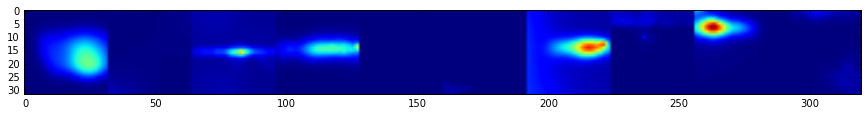

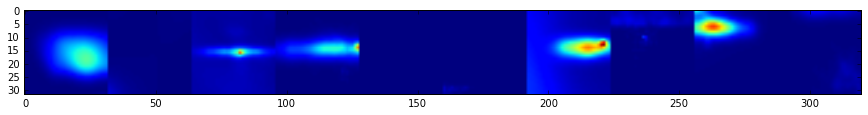

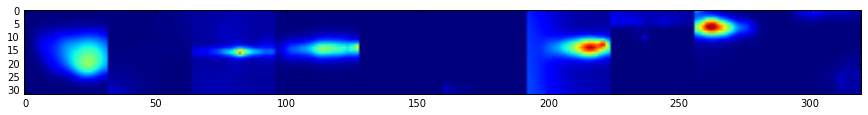

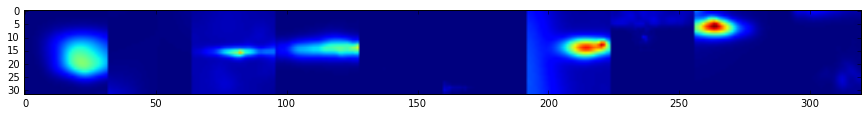

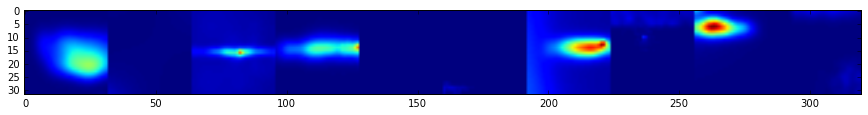

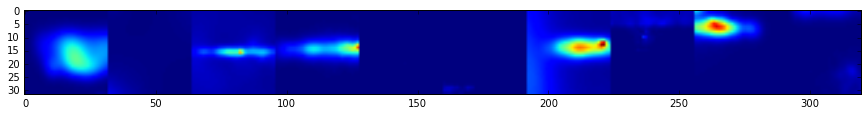

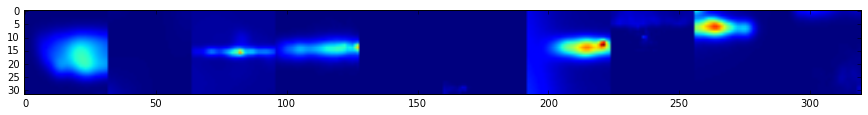

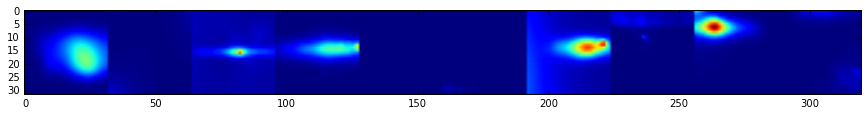

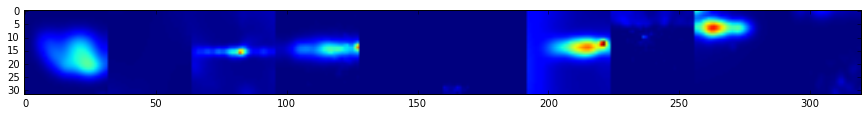

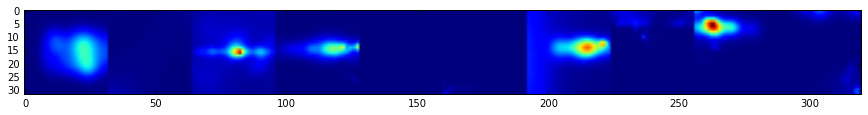

In [40]:
for i in range(10):
    plt.figure(figsize=[15,4])
    plt.imshow(X[i].reshape(-1,32).T)
    plt.show()

In [ ]:
# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(Xts, Yts, batch_size, shuffle=False):
    inputs, targets = batch
    err, acc = eval_fun(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))